<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Using meta_analysis data.

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. Modified R2 score
5. Gene normalization

TODO:
  - Normalize all the data in the same way.
  - Before normalizign the more_data, take care of data with only zeros for the gene expression.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
loss_func = F.mse_loss

In [5]:
class TimeLayer(nn.Module):
    def __init__(self, range = 24):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [6]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [7]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [8]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

<img src="cell_nrm.jpg" alt="Cell normalization" width="400">

In [9]:
def nrm_genes(df):
    """Assuming genes on cols cells on rows."""
    cell_divided = df.div(df.sum(axis=1), axis=0)
    return (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)

In [10]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [11]:
data = nrm_genes(raw_data.set_index('gene').T)
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

In [12]:
raw_data

,gene,AAACAGCCAACCCTAA-6,AAACCAACAGTAAAGC-6,AAACCGAAGGTCCTAG-6,AAAGCACCATTGTCCT-6,AAAGGACGTGAGGTGA-6,AAAGGAGCAAAGCGCA-6,AACAAAGGTAAAGCGG-6,AACAGATAGACTATTG-6,AACATAGCATGAGCAG-6,...,TTAGGATGTTTATCTG-7,TTATCCGTCACCTGCT-7,TTATTGCTCAAGTGTC-7,TTCCTTGAGTAAAGGT-7,TTCGTTAGTAACGAGG-7,TTGCCCGTCGCACAAT-7,TTGCGTCTCTTAGTCT-7,TTGGGTTAGCCACAAT-7,TTTAGCTTCAGGAAGC-7,TTTGGTAAGGAAGTAT-7
0,Meg3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Slc1a2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cyp2c40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cyp2c69,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Sept8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2996,Cfap52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,Arhgap27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,F730043M19Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bulk + scRNA-seq

In [13]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [14]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [16]:
bulk_data = nrm_genes(raw_bulk_data.set_index('ID').T)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [17]:
gro = nrm_genes(raw_gro.set_index('ID').T)
nascent = nrm_genes(raw_nascent.set_index('ID').T)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [18]:
gro.mean(axis=0), gro.std(axis=0)

(ID
 Ldlrap1         -8.049117e-16
 Mfap1b           0.000000e+00
 Rnaset2a        -8.326673e-17
 9130023H24Rik   -3.738329e-16
 Rcc1            -1.346145e-15
                      ...     
 Fgg             -1.387779e-17
 4933434E20Rik   -1.973248e-15
 Taf13           -3.053113e-16
 Tiparp           2.376571e-16
 code             1.150000e+01
 Length: 9482, dtype: float64,
 ID
 Ldlrap1          1.000000
 Mfap1b           1.000000
 Rnaset2a         1.000000
 9130023H24Rik    1.000000
 Rcc1             1.000000
                    ...   
 Fgg              1.000000
 4933434E20Rik    1.000000
 Taf13            1.000000
 Tiparp           1.000000
 code             7.348469
 Length: 9482, dtype: float64)

In [19]:
nascent.mean(axis=0), nascent.std(axis=0)

(ID
 Rorc      -4.625929e-17
 Nr1d1      5.551115e-17
 Zfyve26    2.127927e-16
 Fbxo22    -8.326673e-17
 Ppfibp1    0.000000e+00
                ...     
 Eef1b2    -4.163336e-16
 Mier3      6.892635e-16
 Sec13      1.230497e-15
 Mapk3     -2.891206e-16
 code       1.000000e+01
 Length: 9482, dtype: float64,
 ID
 Rorc       1.000000
 Nr1d1      1.000000
 Zfyve26    1.000000
 Fbxo22     1.000000
 Ppfibp1    1.000000
              ...   
 Eef1b2     1.000000
 Mier3      1.000000
 Sec13      1.000000
 Mapk3      1.000000
 code       7.135061
 Length: 9482, dtype: float64)

## Adding more datasets

See meta_analysis for more data.

In [20]:
path = Path('data/scRNA_datasets')
more_data = pd.read_csv(path/'tpm.by_sample.txt', sep='\t', low_memory=False).dropna(how='any').T.drop(index='Name')
more_data.columns = more_data.loc['Symbol']
more_data = more_data.drop(index='Symbol')

In [21]:
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,Gm13425,4930527E20Rik,Gm13402,AA645442,...,Il33,Pgam1-ps1,Gm22697,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902
GSM2046160,0.047856,0.043026,0.013747,0.0,0.017114,0.184585,0.0,0.0,0.0,0.0,...,0.585986,0.04335,0.0,0.0,0.0,0.0,0.029685,2.69082,0.0,0.0
GSM2046184,0.0,0.017274,0.012649,0.0,0.0,0.225739,0.0,0.0,0.0,0.084449,...,0.682593,0.038878,0.0,0.0,0.0,0.017092,0.031688,2.20585,0.0,0.0
GSM2046157,0.011696,0.012144,0.029259,0.0,0.0,0.246204,0.0,0.0,0.0,0.0,...,0.521939,0.045233,0.0,0.1197,0.0,0.0,0.0,2.56285,0.0,0.015267
GSM2046183,0.038796,0.035352,0.012449,0.0,0.0,0.207048,0.0,0.0,0.0,0.0,...,0.404564,0.017379,0.0,0.170666,0.0,0.0,0.009918,2.47665,0.0,0.0
GSM2046155,0.0,0.025837,0.080033,0.0,0.0,0.157396,0.0,0.0,0.0,0.619891,...,0.36724,0.088547,0.0,0.134558,0.0,0.0,0.007446,2.71046,0.0,0.011883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.0,0.035516,0.215311,0.0,0.0,0.0,0.0,0.0,0.130749,0.316231,...,0.794336,0.3189,0.0,0.0,0.0,0.0,0.023322,1.85593,0.0,0.0
GSM6610724,0.0,0.078964,0.200141,0.0,0.0,0.806385,0.0,0.0,0.0,0.0,...,0.752421,0.165695,0.0,0.110278,0.0,0.0,0.070138,1.70914,0.0,0.0
GSM6610752,0.0,0.043414,0.228735,0.0,0.0,0.447329,0.0,0.0,0.0,0.405717,...,0.796097,0.265712,0.0,0.0,0.0,0.0,0.054193,2.7101,0.0,0.0
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.0,1.18465,0.0,0.0,0.0,0.829571,...,0.715682,0.034111,0.0,0.276602,0.0,0.0,0.047538,1.66776,0.0,0.0


Getting rid of genes that don't express anything.

In [22]:
# Checking which ones are in training data
zero_cols = more_data.loc[:,more_data.sum(axis=0) == 0].columns
len(set(zero_cols).intersection(df.columns))

2

In [23]:
more_data = more_data.drop(zero_cols, axis=1)
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Eef1akmt4,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902
GSM2046160,0.047856,0.043026,0.013747,0.0,0.017114,0.184585,0.0,0.0,0.0,8.55776,...,4.80793,0.585986,0.04335,0.0,0.0,0.0,0.029685,2.69082,0.0,0.0
GSM2046184,0.0,0.017274,0.012649,0.0,0.0,0.225739,0.0,0.0,0.084449,4.54988,...,4.70429,0.682593,0.038878,0.0,0.0,0.017092,0.031688,2.20585,0.0,0.0
GSM2046157,0.011696,0.012144,0.029259,0.0,0.0,0.246204,0.0,0.0,0.0,8.24781,...,3.84295,0.521939,0.045233,0.1197,0.0,0.0,0.0,2.56285,0.0,0.015267
GSM2046183,0.038796,0.035352,0.012449,0.0,0.0,0.207048,0.0,0.0,0.0,8.40232,...,4.45069,0.404564,0.017379,0.170666,0.0,0.0,0.009918,2.47665,0.0,0.0
GSM2046155,0.0,0.025837,0.080033,0.0,0.0,0.157396,0.0,0.0,0.619891,11.4359,...,4.87733,0.36724,0.088547,0.134558,0.0,0.0,0.007446,2.71046,0.0,0.011883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.0,0.035516,0.215311,0.0,0.0,0.0,0.0,0.130749,0.316231,0.0,...,8.84043,0.794336,0.3189,0.0,0.0,0.0,0.023322,1.85593,0.0,0.0
GSM6610724,0.0,0.078964,0.200141,0.0,0.0,0.806385,0.0,0.0,0.0,0.0,...,8.3792,0.752421,0.165695,0.110278,0.0,0.0,0.070138,1.70914,0.0,0.0
GSM6610752,0.0,0.043414,0.228735,0.0,0.0,0.447329,0.0,0.0,0.405717,0.0,...,8.78542,0.796097,0.265712,0.0,0.0,0.0,0.054193,2.7101,0.0,0.0
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.0,1.18465,0.0,0.0,0.829571,1.58835,...,7.12422,0.715682,0.034111,0.276602,0.0,0.0,0.047538,1.66776,0.0,0.0


In [24]:
more_data = nrm_genes(more_data)
more_data.mean(axis=0), more_data.std(axis=0)

(Symbol
 Gm14820    -0.0
 Flicr       0.0
 Gm13449     0.0
 C79798     -0.0
 Nron       -0.0
            ... 
 Rpsa-ps3    0.0
 Gm14634    -0.0
 Zkscan7    -0.0
 Agbl1       0.0
 Gm8902     -0.0
 Length: 32904, dtype: object,
 Symbol
 Gm14820     1.0
 Flicr       1.0
 Gm13449     1.0
 C79798      1.0
 Nron        1.0
            ... 
 Rpsa-ps3    1.0
 Gm14634     1.0
 Zkscan7     1.0
 Agbl1       1.0
 Gm8902      1.0
 Length: 32904, dtype: object)

In [25]:
meta_data = pd.read_csv(path/'sample_metadata.txt', sep='\t', index_col='sample', low_memory=False)
more_data['code'] = meta_data['time']
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902,code
GSM2046160,0.259269,-0.157117,-0.24609,-0.136791,1.989747,-0.360068,-0.058182,-0.171698,-0.470116,2.019621,...,-0.495987,0.179397,-0.319751,-0.045089,-0.227785,-0.340332,0.049125,-0.108363,-0.133167,22.0
GSM2046184,-0.058396,-0.269264,-0.248887,-0.136791,-0.09807,-0.307829,-0.058182,-0.171698,-0.410231,0.846156,...,-0.304115,0.118501,-0.319751,-0.045089,0.115119,-0.308742,-0.296044,-0.108363,-0.133167,22.0
GSM2046157,0.019232,-0.291584,-0.206713,-0.136791,-0.09807,-0.281764,-0.058182,-0.171698,-0.470116,1.928629,...,-0.623569,0.204906,0.920292,-0.045089,-0.227785,-0.810639,-0.042041,-0.108363,0.282452,10.0
GSM2046183,0.198919,-0.190655,-0.249412,-0.136791,-0.09807,-0.331724,-0.058182,-0.171698,-0.470116,1.972117,...,-0.857706,-0.173566,1.447035,-0.045089,-0.227785,-0.653634,-0.104544,-0.108363,-0.133167,18.0
GSM2046155,-0.058396,-0.231989,-0.077843,-0.136791,-0.09807,-0.394689,-0.058182,-0.171698,-0.030527,2.861126,...,-0.931528,0.792993,1.073994,-0.045089,-0.227785,-0.692702,0.062562,-0.108363,0.190277,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,-0.058396,-0.188282,0.27111,-0.136791,-0.09807,-0.594739,-0.058182,5.690522,-0.243579,-0.485181,...,-0.065659,3.965212,-0.319751,-0.045089,-0.227785,-0.437478,-0.531234,-0.108363,-0.133167,13.5
GSM6610724,-0.058396,0.003074,0.232662,-0.136791,-0.09807,0.441533,-0.058182,-0.171698,-0.470116,-0.485181,...,-0.148572,1.865558,0.835159,-0.045089,-0.227785,0.312584,-0.635527,-0.108363,-0.133167,7.5
GSM6610752,-0.058396,-0.154137,0.303737,-0.136791,-0.09807,-0.022147,-0.058182,-0.171698,-0.180364,-0.485181,...,-0.067015,3.22443,-0.319751,-0.045089,-0.227785,0.053816,0.075979,-0.108363,-0.133167,19.5
GSM6610726,0.051729,-0.152073,0.446019,2.480244,-0.09807,0.92337,-0.058182,-0.171698,0.123017,-0.016574,...,-0.226513,0.057596,2.568907,-0.045089,-0.227785,-0.051476,-0.668614,-0.108363,-0.133167,7.5


In `more_data`, there are duplicate genes, such as '4930594M22Rik'.

In [26]:
more_data.columns.duplicated().sum()

27

In [27]:
more_data = more_data.loc[:, ~more_data.columns.duplicated(keep='first')]

In [28]:
more_data.columns.duplicated().sum()

0

In [29]:
bulk_genes_set = set(raw_bulk_data['ID'])
sc_genes = set(raw_data['gene'])

In [30]:
len(bulk_genes_set.intersection(sc_genes))

1573

In [31]:
genes = list(bulk_genes_set.intersection(sc_genes))

In [32]:
mis_genes = list(sc_genes.difference(bulk_genes_set))

`df2` is the bulk data used for testing.

In [33]:
df2 = pd.DataFrame(np.zeros((12, 6000), dtype=int), columns=data2.columns)

In [34]:
for gene in genes:
    df2[gene] = bulk_data[gene].values

In [35]:
for gene in sc_genes:
    if gene not in bulk_genes_set:
        df2[f'{gene}_missing'] = 1

In [36]:
df2['code'] = bulk_data['code'].values.astype(float)

/tmp/ipykernel_11182/1075454734.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['code'] = bulk_data['code'].values.astype(float)


In [37]:
def make_df(dataset):
    genes_set = set(dataset.columns[:-1])
    genes = [gene for gene in sc_genes if gene in genes_set]
    mis_genes = [gene for gene in sc_genes if gene not in genes_set]
    df = pd.DataFrame(np.zeros((dataset.shape[0], 6000), dtype=int), columns=data2.columns)
    for gene in genes:
        df[gene] = dataset[gene].values
    for gene in sc_genes:
        if gene not in genes_set:
            df[f'{gene}_missing'] = 1
    df['code'] = dataset['code'].values.astype(float)
    print(f'% missing: {len(mis_genes)/3000*100}%')
    return df.fillna(0)

In [38]:
nascent_df = make_df(nascent)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)
more_df = make_df(more_data)

/tmp/ipykernel_11182/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


/tmp/ipykernel_11182/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


/tmp/ipykernel_11182/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


/tmp/ipykernel_11182/3986161752.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)
/tmp/ipykernel_11182/3986161752.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.fillna(0)


% missing: 2.0666666666666664%


In [39]:
df.iloc[:,:-2].mean(axis=0)

Meg3                    -2.843593e-17
Slc1a2                  -1.137437e-16
Rian                    -7.108982e-18
Cyp2c40                 -1.386251e-16
Cyp2c69                  6.042635e-17
                             ...     
Sept8_missing            0.000000e+00
Cfap52_missing           0.000000e+00
Arhgap27_missing         0.000000e+00
F730043M19Rik_missing    0.000000e+00
Bora_missing             0.000000e+00
Length: 6000, dtype: float64

In [40]:
df.iloc[:,:-2].std(axis=0)

Meg3                     1.0
Slc1a2                   1.0
Rian                     1.0
Cyp2c40                  1.0
Cyp2c69                  1.0
                        ... 
Sept8_missing            0.0
Cfap52_missing           0.0
Arhgap27_missing         0.0
F730043M19Rik_missing    0.0
Bora_missing             0.0
Length: 6000, dtype: float64

In [41]:
more_df.mean(axis=0)

Meg3                     5.964410e-16
Slc1a2                   2.363073e-15
Rian                    -5.186443e-17
Cyp2c40                 -1.555933e-16
Cyp2c69                  4.149155e-16
                             ...     
Cfap52_missing           0.000000e+00
Arhgap27_missing         0.000000e+00
F730043M19Rik_missing    0.000000e+00
Bora_missing             0.000000e+00
code                     1.359398e+01
Length: 6001, dtype: float64

In [42]:
nascent_df.iloc[:,:-1].mean(axis=0)

Meg3                     0.000000e+00
Slc1a2                  -1.295260e-16
Rian                     0.000000e+00
Cyp2c40                  0.000000e+00
Cyp2c69                  0.000000e+00
                             ...     
Sept8_missing            1.000000e+00
Cfap52_missing           1.000000e+00
Arhgap27_missing         0.000000e+00
F730043M19Rik_missing    1.000000e+00
Bora_missing             1.000000e+00
Length: 6000, dtype: float64

## Using Pytorch

In [43]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-2]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_11182/3413784403.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [44]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [45]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [46]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([12794, 1]), torch.Size([3198, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [47]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 6000]), torch.Size([128, 1]))

In [48]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [49]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
more_dl = make_dl(more_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl, 'more': more_dl}

Changing the metric to R2Score.

In [50]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [51]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [52]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [53]:
get_model()(xb).shape

torch.Size([128, 1])

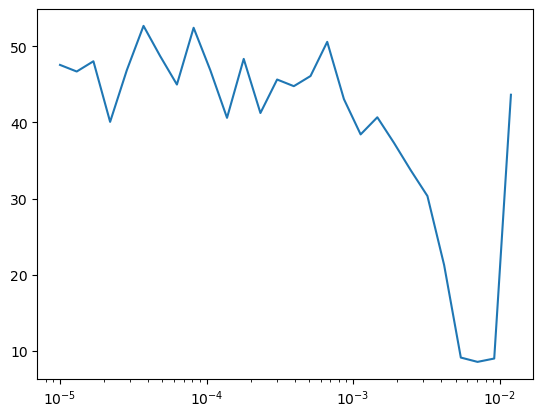

In [54]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.835,7.769,0,True,00:02
0.966,1.583,0,False,00:00
0.981,0.887,1,True,00:02
0.971,1.343,1,False,00:00


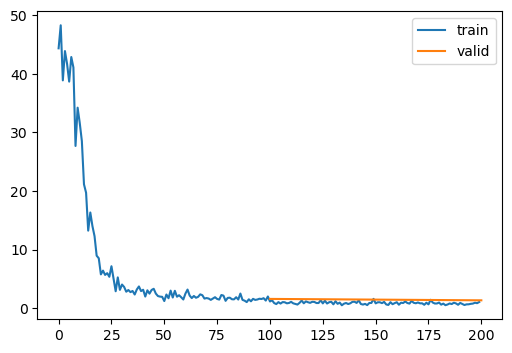

In [55]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [56]:
from functools import partial

In [57]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [70]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    preds = {}
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        preds[dl_name] = torch.concat([ap, cps[0].all_targs], dim=1)  # Saving predictions
        print('result: ', metric.compute())
    return preds

In [71]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.759,11.938,0,True,00:02
0.929,3.327,0,False,00:00
0.916,3.957,1,True,00:02
0.948,2.438,1,False,00:01


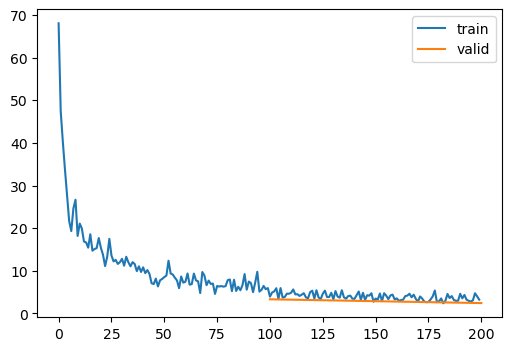

TimeR2Score,loss,epoch,train,time
0.770,11.438,0,True,00:03
0.930,3.267,0,False,00:01
0.916,3.962,1,True,00:02
0.949,2.361,1,False,00:00


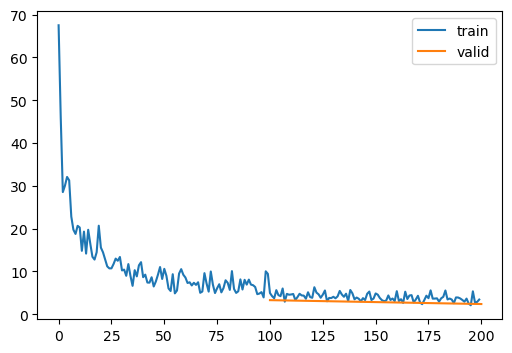

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.655,16.122,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.489,27.576,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 7.2109,  0.0000],
        [ 7.1579,  4.0000],
        [10.1418,  8.0000],
        [11.6959, 12.0000],
        [12.6772, 16.0000],
        [19.4868, 20.0000],
        [11.3649,  0.0000],
        [ 4.1661,  4.0000],
        [12.2663,  8.0000],
        [10.9881, 12.0000],
        [20.7932, 16.0000],
        [21.7588, 20.0000]])
result:  tensor(0.5492)


TimeR2Score,loss,epoch,train,time
0.746,28.910,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.829,40.291,0,False,00:00


Inference on gro
		preds, targs
tensor([[17.0936,  1.0000],
        [ 5.7705,  4.0000],
        [ 8.2173,  7.0000],
        [ 9.8805, 10.0000],
        [13.1424, 13.0000],
        [14.1815, 16.0000],
        [19.5096, 19.0000],
        [19.3905, 22.0000]])
result:  tensor(0.7949)


TimeR2Score,loss,epoch,train,time
0.604,18.492,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.622,17.639,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 8.5842,  2.0000],
        [10.3372,  6.0000],
        [ 8.6179, 10.0000],
        [13.3904, 14.0000],
        [18.9938, 18.0000],
        [21.4934, 22.0000],
        [10.0630,  2.0000],
        [ 9.7853,  6.0000],
        [11.4139, 10.0000],
        [11.0420, 14.0000],
        [19.9371, 18.0000],
        [14.5320, 22.0000]])
result:  tensor(0.6155)


TimeR2Score,loss,epoch,train,time
0.742,119.940,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.757,118.754,0,False,00:03


Inference on more
		preds, targs
tensor([[13.3089, 22.0000],
        [15.0685, 22.0000],
        [10.7691, 10.0000],
        [14.4554, 18.0000],
        [13.4014,  2.0000],
        [15.4911, 18.0000],
        [12.1472, 14.0000],
        [ 7.7567,  6.0000],
        [10.2257,  6.0000],
        [11.6013, 14.0000],
        [11.2177, 10.0000],
        [14.0456,  2.0000],
        [20.3806, 24.0000],
        [19.2651, 21.0000],
        [ 6.5286, 33.0000],
        ...,
        [10.5910,  7.5000],
        [20.9860,  1.5000],
        [16.6372, 16.5000],
        [15.2198,  4.5000],
        [20.7964, 22.5000],
        [15.4518, 16.5000],
        [20.7831,  1.5000],
        [11.5825, 10.5000],
        [14.4614, 16.5000],
        [20.5741,  1.5000],
        [13.1797, 13.5000],
        [11.5209,  7.5000],
        [19.7411, 19.5000],
        [11.4951,  7.5000],
        [11.5907, 13.5000]])
result:  tensor(0.7495)


In [72]:
preds = ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [73]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [74]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

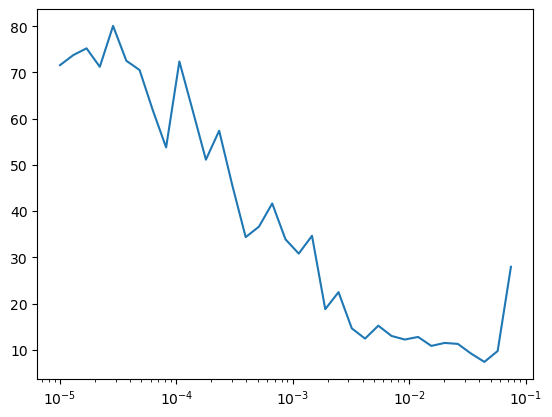

In [63]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.889,5.692,0,True,00:04
0.941,3.132,0,False,00:01
0.937,3.157,1,True,00:05
0.947,2.878,1,False,00:01
0.966,1.617,2,True,00:05
0.978,1.102,2,False,00:01
0.978,1.052,3,True,00:04
0.980,0.992,3,False,00:01


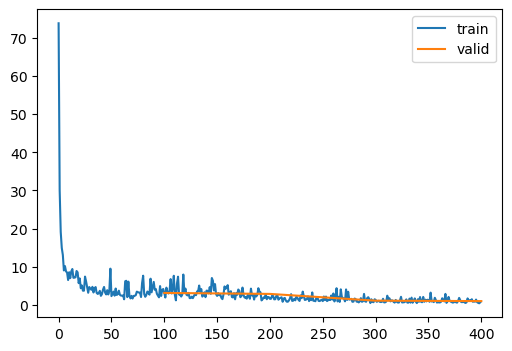

TimeR2Score,loss,epoch,train,time
0.899,5.139,0,True,00:05
0.935,3.417,0,False,00:01
0.935,3.337,1,True,00:05
0.938,3.299,1,False,00:01
0.963,1.761,2,True,00:04
0.969,1.601,2,False,00:01
0.980,0.960,3,True,00:04
0.980,1.073,3,False,00:01


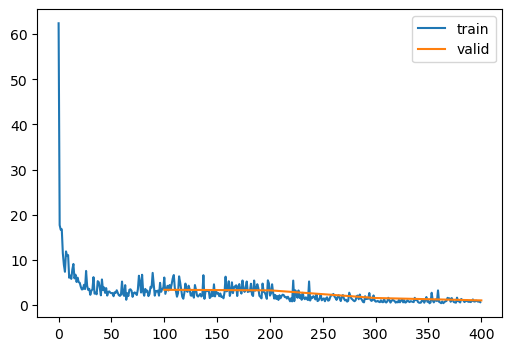

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.841,7.418,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.854,6.825,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.1954,  0.0000],
        [ 6.2056,  4.0000],
        [ 7.1820,  8.0000],
        [10.2031, 12.0000],
        [14.3637, 16.0000],
        [18.7217, 20.0000],
        [ 5.8307,  0.0000],
        [ 2.6574,  4.0000],
        [10.8334,  8.0000],
        [10.7364, 12.0000],
        [20.3849, 16.0000],
        [20.6364, 20.0000]])
result:  tensor(0.8519)


TimeR2Score,loss,epoch,train,time
0.838,7.664,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.619,17.991,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 9.8794,  1.0000],
        [ 6.4154,  4.0000],
        [ 7.4179,  7.0000],
        [ 9.3125, 10.0000],
        [13.6468, 13.0000],
        [14.0344, 16.0000],
        [18.5376, 19.0000],
        [19.5404, 22.0000]])
result:  tensor(0.7464)


TimeR2Score,loss,epoch,train,time
0.845,7.241,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.795,9.545,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 3.4724,  2.0000],
        [ 7.4873,  6.0000],
        [ 9.3571, 10.0000],
        [14.3568, 14.0000],
        [18.7476, 18.0000],
        [20.6454, 22.0000],
        [ 3.5104,  2.0000],
        [ 7.1328,  6.0000],
        [10.2753, 10.0000],
        [11.8293, 14.0000],
        [20.2661, 18.0000],
        [13.1770, 22.0000]])
result:  tensor(0.8238)


TimeR2Score,loss,epoch,train,time
0.776,123.953,0,False,00:06


TimeR2Score,loss,epoch,train,time
0.782,117.795,0,False,00:03


Inference on more
		preds, targs
tensor([[14.6024, 22.0000],
        [16.9450, 22.0000],
        [ 9.3452, 10.0000],
        ...,
        [19.6316, 19.5000],
        [13.4849,  7.5000],
        [10.6631, 13.5000]])
result:  tensor(0.7794)


In [64]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.890,5.674,0,True,00:02
0.932,3.525,0,False,00:00
0.950,2.497,1,True,00:02
0.968,1.729,1,False,00:00
0.971,1.434,2,True,00:02
0.977,1.133,2,False,00:00
0.981,0.879,3,True,00:04
0.980,0.978,3,False,00:01


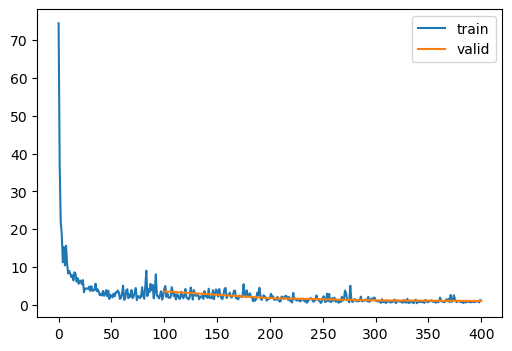

TimeR2Score,loss,epoch,train,time
0.890,5.704,0,True,00:05
0.936,3.309,0,False,00:01
0.951,2.395,1,True,00:05
0.966,1.857,1,False,00:01
0.971,1.365,2,True,00:05
0.974,1.340,2,False,00:01
0.981,0.883,3,True,00:05
0.980,1.072,3,False,00:01


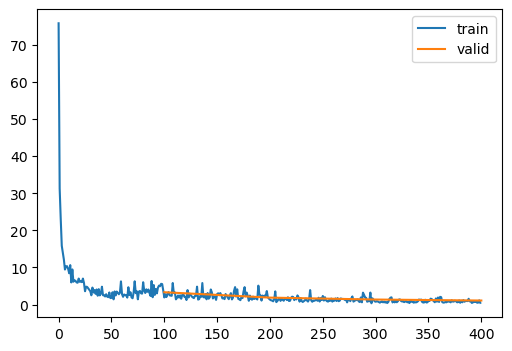

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.837,7.607,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.821,8.341,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.4545,  0.0000],
        [ 5.9121,  4.0000],
        [ 7.3124,  8.0000],
        [ 9.9577, 12.0000],
        [14.3150, 16.0000],
        [18.3417, 20.0000],
        [ 6.0469,  0.0000],
        [ 2.8912,  4.0000],
        [10.8494,  8.0000],
        [10.4910, 12.0000],
        [21.1655, 16.0000],
        [20.5206, 20.0000]])
result:  tensor(0.8303)


TimeR2Score,loss,epoch,train,time
0.750,11.805,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.820,8.492,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 9.4912,  1.0000],
        [ 4.4197,  4.0000],
        [ 7.7590,  7.0000],
        [ 9.5337, 10.0000],
        [13.6470, 13.0000],
        [14.9926, 16.0000],
        [18.7857, 19.0000],
        [19.6477, 22.0000]])
result:  tensor(0.7881)


TimeR2Score,loss,epoch,train,time
0.850,6.996,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.938,2.886,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.5215,  2.0000],
        [ 7.0327,  6.0000],
        [ 9.4536, 10.0000],
        [14.0181, 14.0000],
        [19.1539, 18.0000],
        [20.7446, 22.0000],
        [ 5.3448,  2.0000],
        [ 6.7511,  6.0000],
        [10.1290, 10.0000],
        [12.1602, 14.0000],
        [19.5730, 18.0000],
        [16.2340, 22.0000]])
result:  tensor(0.9010)


TimeR2Score,loss,epoch,train,time
0.784,122.621,0,False,00:06


TimeR2Score,loss,epoch,train,time
0.794,125.401,0,False,00:06


Inference on more
		preds, targs
tensor([[16.4257, 22.0000],
        [18.6322, 22.0000],
        [ 9.1168, 10.0000],
        ...,
        [19.9208, 19.5000],
        [ 9.6717,  7.5000],
        [10.8577, 13.5000]])
result:  tensor(0.7875)


In [65]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.896,5.372,0,True,00:05
0.950,2.815,0,False,00:01
0.928,3.736,1,True,00:05
0.916,4.633,1,False,00:01
0.953,2.261,2,True,00:05
0.971,1.669,2,False,00:01
0.971,1.403,3,True,00:04
0.975,1.302,3,False,00:01
0.980,0.920,4,True,00:04
0.981,1.031,4,False,00:01


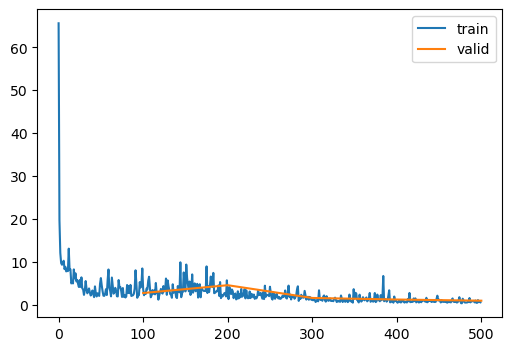

TimeR2Score,loss,epoch,train,time
0.897,5.252,0,True,00:04
0.924,4.156,0,False,00:01
0.929,3.548,1,True,00:04
0.951,2.728,1,False,00:01
0.951,2.391,2,True,00:05
0.969,1.585,2,False,00:01
0.969,1.506,3,True,00:04
0.973,1.370,3,False,00:01
0.979,0.993,4,True,00:05
0.981,1.016,4,False,00:01


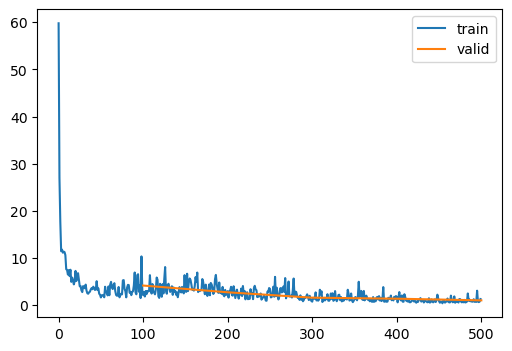

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.838,7.564,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.849,7.052,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.2462,  0.0000],
        [ 6.0349,  4.0000],
        [ 7.3113,  8.0000],
        [10.2524, 12.0000],
        [13.9813, 16.0000],
        [18.4691, 20.0000],
        [ 6.3293,  0.0000],
        [ 2.4600,  4.0000],
        [10.6948,  8.0000],
        [10.7646, 12.0000],
        [20.0624, 16.0000],
        [20.0932, 20.0000]])
result:  tensor(0.8449)


TimeR2Score,loss,epoch,train,time
0.697,14.297,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.580,21.272,0,False,00:00


Inference on gro
		preds, targs
tensor([[12.2225,  1.0000],
        [ 4.7246,  4.0000],
        [ 7.9529,  7.0000],
        [ 9.5663, 10.0000],
        [13.9933, 13.0000],
        [14.3339, 16.0000],
        [18.4002, 19.0000],
        [19.0180, 22.0000]])
result:  tensor(0.6281)


TimeR2Score,loss,epoch,train,time
0.851,6.963,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.861,6.497,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.1968,  2.0000],
        [ 7.2755,  6.0000],
        [ 9.1036, 10.0000],
        [13.7210, 14.0000],
        [18.6598, 18.0000],
        [21.0190, 22.0000],
        [ 3.7667,  2.0000],
        [ 7.1423,  6.0000],
        [10.4694, 10.0000],
        [11.4106, 14.0000],
        [19.5520, 18.0000],
        [14.1696, 22.0000]])
result:  tensor(0.8589)


TimeR2Score,loss,epoch,train,time
0.787,121.353,0,False,00:05


TimeR2Score,loss,epoch,train,time
0.777,124.235,0,False,00:05


Inference on more
		preds, targs
tensor([[15.3798, 22.0000],
        [16.9501, 22.0000],
        [ 9.1870, 10.0000],
        ...,
        [20.0385, 19.5000],
        [10.4587,  7.5000],
        [10.7880, 13.5000]])
result:  tensor(0.7814)


In [66]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.889,5.474,0,True,00:03
0.963,1.998,0,False,00:00
0.953,2.365,1,True,00:02
0.962,2.163,1,False,00:00
0.963,1.805,2,True,00:02
0.969,1.752,2,False,00:00
0.978,1.029,3,True,00:02
0.983,0.942,3,False,00:00
0.983,0.856,4,True,00:03
0.984,0.838,4,False,00:01


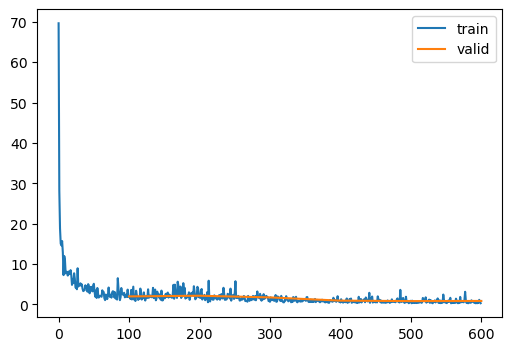

TimeR2Score,loss,epoch,train,time
0.893,5.338,0,True,00:02
0.962,2.124,0,False,00:00
0.953,2.275,1,True,00:02
0.965,1.912,1,False,00:01
0.966,1.638,2,True,00:03
0.979,1.226,2,False,00:00
0.979,0.980,3,True,00:02
0.985,0.752,3,False,00:00
0.984,0.739,4,True,00:02
0.987,0.641,4,False,00:00


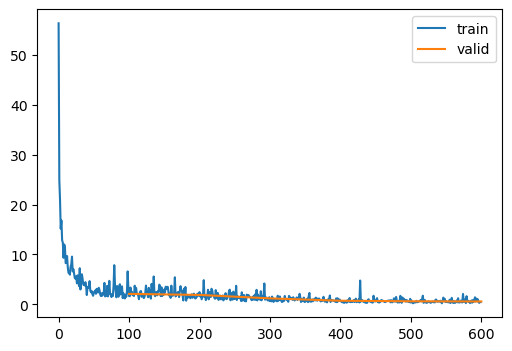

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.847,7.128,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.876,5.763,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.1313,  0.0000],
        [ 5.9040,  4.0000],
        [ 7.0677,  8.0000],
        [10.0401, 12.0000],
        [13.7712, 16.0000],
        [18.1553, 20.0000],
        [ 5.0367,  0.0000],
        [ 2.8203,  4.0000],
        [10.8214,  8.0000],
        [10.3204, 12.0000],
        [20.0891, 16.0000],
        [19.5452, 20.0000]])
result:  tensor(0.8648)


TimeR2Score,loss,epoch,train,time
0.692,28.361,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.665,23.601,0,False,00:00


Inference on gro
		preds, targs
tensor([[14.7986,  1.0000],
        [ 5.5449,  4.0000],
        [ 7.0761,  7.0000],
        [ 9.5293, 10.0000],
        [13.7671, 13.0000],
        [13.7460, 16.0000],
        [18.4909, 19.0000],
        [19.2210, 22.0000]])
result:  tensor(0.6817)


TimeR2Score,loss,epoch,train,time
0.868,6.165,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.748,15.219,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 1.6553,  2.0000],
        [ 6.9343,  6.0000],
        [ 9.5699, 10.0000],
        [13.5111, 14.0000],
        [19.0466, 18.0000],
        [20.8883, 22.0000],
        [ 2.6115,  2.0000],
        [ 6.9862,  6.0000],
        [10.2864, 10.0000],
        [11.2731, 14.0000],
        [19.4725, 18.0000],
        [11.6975, 22.0000]])
result:  tensor(0.7841)


TimeR2Score,loss,epoch,train,time
0.775,119.207,0,False,00:02


TimeR2Score,loss,epoch,train,time
0.783,124.079,0,False,00:02


Inference on more
		preds, targs
tensor([[13.6770, 22.0000],
        [17.2680, 22.0000],
        [ 8.8597, 10.0000],
        [14.0281, 18.0000],
        [14.7311,  2.0000],
        [14.1554, 18.0000],
        [10.6923, 14.0000],
        [ 7.0058,  6.0000],
        [ 9.1240,  6.0000],
        [10.2379, 14.0000],
        [ 9.8199, 10.0000],
        [16.5399,  2.0000],
        [20.2503, 24.0000],
        [16.5741, 21.0000],
        [ 6.5463, 33.0000],
        ...,
        [ 8.0828,  7.5000],
        [20.9234,  1.5000],
        [13.9771, 16.5000],
        [19.6712,  4.5000],
        [19.0621, 22.5000],
        [13.8411, 16.5000],
        [21.3396,  1.5000],
        [10.3286, 10.5000],
        [14.1399, 16.5000],
        [22.3283,  1.5000],
        [12.7096, 13.5000],
        [ 9.8118,  7.5000],
        [19.1612, 19.5000],
        [ 8.6036,  7.5000],
        [10.4383, 13.5000]])
result:  tensor(0.7787)


In [75]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [76]:
df = pd.DataFrame(preds['more'], columns=['preds', 'targets'])
df

,preds,targets
0,13.676980,22.0
1,17.267952,22.0
2,8.859705,10.0
3,14.028101,18.0
4,14.731050,2.0
...,...,...
1091,12.709584,13.5
1092,9.811840,7.5
1093,19.161165,19.5
1094,8.603572,7.5


In [77]:
df.to_csv('preds_3000.csv')

In [68]:
torch.set_printoptions(edgeitems=15, linewidth=100)

Training models


TimeR2Score,loss,epoch,train,time
0.886,6.126,0,True,00:02
0.949,2.875,0,False,00:00


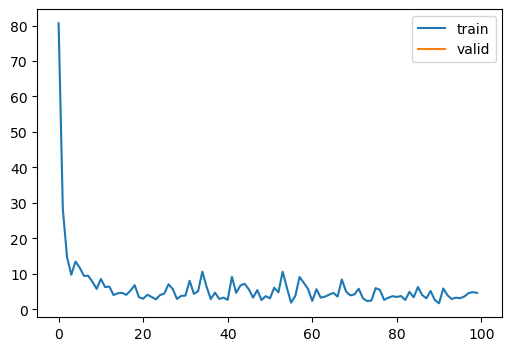

TimeR2Score,loss,epoch,train,time
0.892,5.638,0,True,00:02
0.952,2.360,0,False,00:00


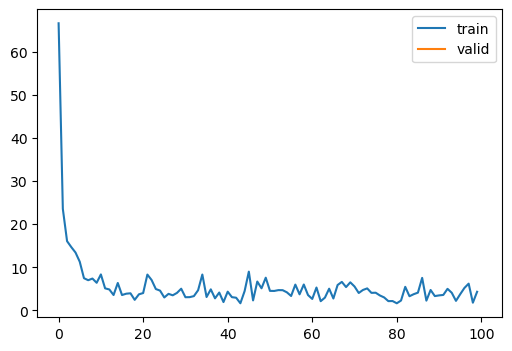

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.566,20.260,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.696,14.193,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 9.0005,  0.0000],
        [ 5.5782,  4.0000],
        [ 8.9177,  8.0000],
        [ 9.8451, 12.0000],
        [13.8168, 16.0000],
        [20.0905, 20.0000],
        [ 8.4018,  0.0000],
        [ 1.7447,  4.0000],
        [ 9.8518,  8.0000],
        [10.1773, 12.0000],
        [20.2569, 16.0000],
        [21.8622, 20.0000]])
result:  tensor(0.6468)


TimeR2Score,loss,epoch,train,time
0.924,49.781,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.902,47.136,0,False,00:00


Inference on gro
		preds, targs
tensor([[20.3919,  1.0000],
        [ 5.0003,  4.0000],
        [ 7.8578,  7.0000],
        [ 9.1534, 10.0000],
        [13.1899, 13.0000],
        [13.3000, 16.0000],
        [19.6668, 19.0000],
        [21.2226, 22.0000]])
result:  tensor(0.9152)


TimeR2Score,loss,epoch,train,time
0.903,4.512,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.875,5.816,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 4.4783,  2.0000],
        [ 7.8548,  6.0000],
        [ 8.6972, 10.0000],
        [13.8361, 14.0000],
        [20.7360, 18.0000],
        [21.4478, 22.0000],
        [ 4.1608,  2.0000],
        [ 7.9010,  6.0000],
        [ 9.9052, 10.0000],
        [11.4693, 14.0000],
        [21.6245, 18.0000],
        [18.5190, 22.0000]])
result:  tensor(0.8946)


TimeR2Score,loss,epoch,train,time
0.744,126.320,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.767,128.361,0,False,00:03


Inference on more
		preds, targs
tensor([[15.7006, 22.0000],
        [17.2438, 22.0000],
        [ 8.6149, 10.0000],
        [15.3921, 18.0000],
        [14.8460,  2.0000],
        [16.7544, 18.0000],
        [11.1260, 14.0000],
        [ 6.5022,  6.0000],
        [ 9.1368,  6.0000],
        [10.5788, 14.0000],
        [ 8.8183, 10.0000],
        [14.6338,  2.0000],
        [19.2705, 24.0000],
        [15.7491, 21.0000],
        [ 7.7115, 33.0000],
        ...,
        [ 9.8264,  7.5000],
        [20.8147,  1.5000],
        [16.7861, 16.5000],
        [19.5076,  4.5000],
        [20.6516, 22.5000],
        [16.1838, 16.5000],
        [21.7538,  1.5000],
        [11.0779, 10.5000],
        [13.4316, 16.5000],
        [21.9429,  1.5000],
        [13.0844, 13.5000],
        [11.0573,  7.5000],
        [19.7237, 19.5000],
        [12.8558,  7.5000],
        [11.1314, 13.5000]])
result:  tensor(0.7540)


In [69]:
lr, epochs = .3, 1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)